# Workplace Attendance forecasting with Prophet

Forecasting workplace attendance allow businesses to right-size their investment in office space with confidence. It can also be an input for other types of Corporate forecastings i.e. number of meals to be served at the corporate restaurant.

Facebook Prophet is a forecasting package in both R and Python that was developed by Meta's data science research team (formerly Facebook).

🎯 The goal of the package is to give business users a powerful and easy-to-use tool to help forecast business results without needing to be an expert in time series analysis.

Facebook Prophet
https://facebook.github.io/prophet/docs/quick_start.html#python-api


## Dataset

Due to the confidentiality of HR data, it is already quite difficult to find HR datasets. It is even more complicated with HR time-series-based dataset...

             ➡️ So, I decided to create my own! 

🕵🏻 I imagined that traffic data (road/transport) could be a good approximation to workplace attendance data. 

💡 After a few searchs, I found the "permanent road counts" dataset provided by OpenData PARIS under ODbL License. 

🇫🇷 On the Parisian network, traffic measurement is mainly carried out through electromagnetic loops implanted in the road. These data provide an overview of the traffic flow 🚕 over 3,000 road sections every hour every day. The dataset is only available for the last 13 rolling months. Historical data can be retrieved here.

From this dataset, I selected a subset:

    One road section in the center of Paris "4 Septembre/Richelieu", good place for work offices (and for Japanese food!). 
    One hour in the day: 09:00 AM, good time to measure road traffic related to work.

You can have a look at my workplace attendance dataset creation with Python on my GitHub here. 

    It includes web scrapping, management of missing values & unexpected outliers. 
    It also includes additional the applications of linear coefficients for weekend days, fridays & vacation periods. 
    It also introduces a monthly headcount calculation based on random distributions of newcomers and leavers per month. The corresponfing monthly ratios are then applied linearly to the workplace attendance figures. 

The final dataset contains 3 columns:

    Date (from 1 Dec 2022 to 24 Jan 2023)
    Work Place attendance (per day)
    Headcount (on that day)

## Step 1: Install and Import Libraries

In [169]:
pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [170]:
from google.colab import drive
import os
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [171]:
%cd /content/gdrive/My\ Drive/Colab\ Notebooks/PRJ-Predict onsite staff attendance/

/content/gdrive/My Drive/Colab Notebooks/PRJ-Predict onsite staff attendance


In [172]:
# import the necessary libraries

# Prophet model for time series forecast
from prophet import Prophet
from prophet.plot import plot_plotly, add_changepoints_to_plot

from datetime import datetime

# Data processing
import numpy as np             
import pandas as pd 
pd.set_option('display.max_columns', None)
plotsize = (13, 5)

# Visualization
import matplotlib.pyplot as plt 
%matplotlib inline 
plt.rcParams["figure.figsize"] = (16,6)

import seaborn as sns

# Model performance evaluation
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

import warnings
warnings.filterwarnings('ignore')


## Step 2: Pull data

In [173]:
# Data start date
start_date = '2021-12-01'

# Data end date. yfinance excludes the end date, so we need to add one day to the last day of data
end_date = '2023-01-24' # Date for splitting training and testing dataset

# Date for splitting training and testing dataset
train_end_date = '2022-11-30'

In [174]:
df = pd.read_csv('WorkplaceAttendanceDec21-Jan23.csv')
df

,Date,WPAtt,headcount
0,2021-12-01,579.0,750
1,2021-12-02,504.0,750
2,2021-12-03,571.0,750
3,2021-12-04,25.0,750
4,2021-12-05,14.0,750
...,...,...,...
415,2023-01-20,698.0,966
416,2023-01-21,40.0,966
417,2023-01-22,23.0,966
418,2023-01-23,862.0,966


In [175]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420 entries, 0 to 419
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       420 non-null    object 
 1   WPAtt      420 non-null    float64
 2   headcount  420 non-null    int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 10.0+ KB


## Step 3: Exploratory Data Analysis

### Original time series

In [176]:
df.Date = pd.to_datetime(df.Date)

In [177]:
df.shape

(420, 3)

In [178]:
# Set date as index
df.set_index('Date', inplace=True)

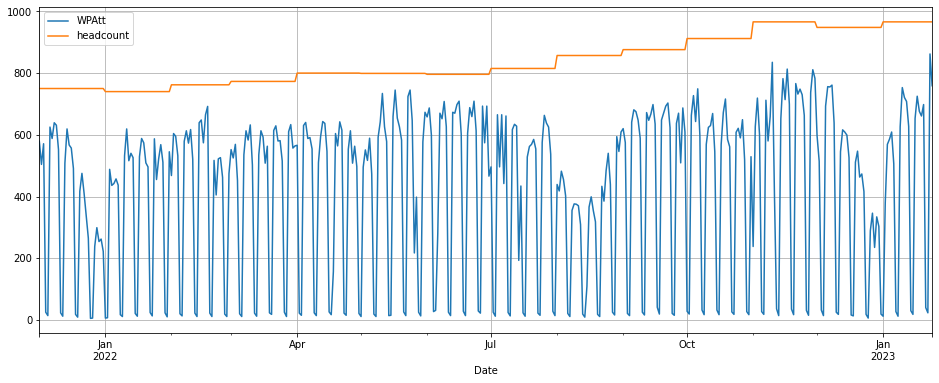

In [179]:
# plot data
df.plot()
plt.grid();

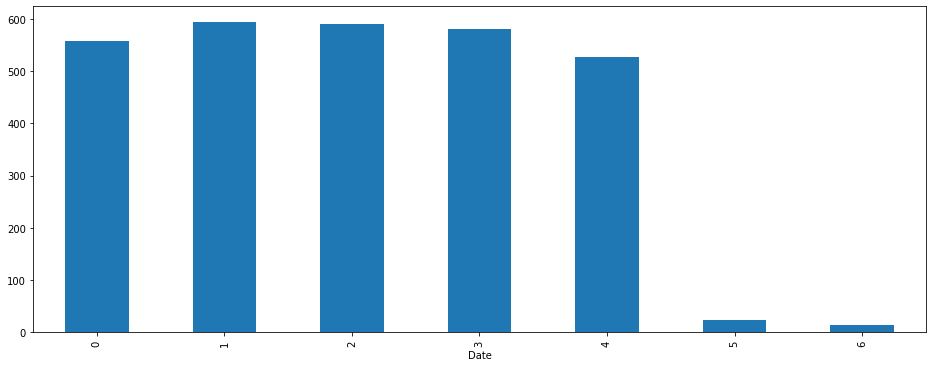

In [180]:
# Display average per weekday
df['WPAtt'].groupby(df.index.weekday).mean().plot(kind='bar', legend=None)

### Time series without weekend days

In [181]:
df = df.reset_index()

In [182]:
df=df[(df['Date'].dt.day_name()!='Saturday') & (df['Date'].dt.day_name()!='Sunday')]

In [183]:
df.shape

(300, 3)

In [184]:
# Set date as index
df.set_index('Date', inplace=True)

In [185]:
df

,WPAtt,headcount
Date,,
2021-12-01,579.0,750
2021-12-02,504.0,750
2021-12-03,571.0,750
2021-12-06,625.0,750
2021-12-07,588.0,750
...,...,...
2023-01-18,676.0,966
2023-01-19,661.0,966
2023-01-20,698.0,966


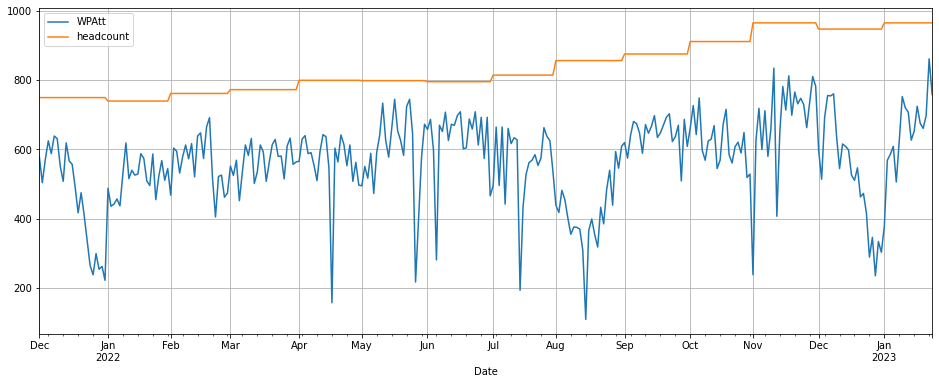

In [186]:
# plot data
df.plot()
plt.grid();

## Step 4: Data Processing

Prophet requires at least 2 columns as inputs: 
- a 'ds' column 
- a 'y' column

    The ds column has the time information. Currently we have the date as the index, so we reset the index and rename date to ds.
    The y column has the time series values. The column name 'WPAtt' is changed to y.
    There is no pre-defined name for the additional predictor in prophet, so we can keep the name 'headcount' as it is.

In [187]:
# Change variable names
df = df.reset_index()
df.columns = ['ds', 'y', 'headcount']

In [188]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   ds         300 non-null    datetime64[ns]
 1   y          300 non-null    float64       
 2   headcount  300 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 7.2 KB


In [189]:
df.ds = pd.to_datetime(df.ds)

In [190]:
df.head()

,ds,y,headcount
0,2021-12-01,579.0,750
1,2021-12-02,504.0,750
2,2021-12-03,571.0,750
3,2021-12-06,625.0,750
4,2021-12-07,588.0,750


In [191]:
# Check correlation
df.corrwith(df["y"])

y            1.00000
headcount    0.25551
dtype: float64

The correlation between 'headcount' and 'WPAtt' is 25%.

## Step 5: Train Test Split

In [192]:
# Train test split
train = df[df['ds'] <= train_end_date]
test = df[df['ds'] > train_end_date]

In [193]:
# Check the shape of the dataset
print(train.shape)
print(test.shape)

(261, 3)
(39, 3)


In [194]:
# Check the start and end time of the training and testing dataset
print('The start time of the training dataset is ', train['ds'].min())
print('The end time of the training dataset is ', train['ds'].max())
print('The start time of the testing dataset is ', test['ds'].min())
print('The end time of the testing dataset is ', test['ds'].max())

The start time of the training dataset is  2021-12-01 00:00:00
The end time of the training dataset is  2022-11-30 00:00:00
The start time of the testing dataset is  2022-12-01 00:00:00
The end time of the testing dataset is  2023-01-24 00:00:00


## Step 6: Modeling

### 6.1: Baseline Model

In [195]:
# Use the default hyperparameters to initiate the Prophet model
model_baseline = Prophet()

In [196]:
# Fit the model on the training dataset
model_baseline.fit(train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpon5sxtje/7qhmq02a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpon5sxtje/o7mpcc2w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45831', 'data', 'file=/tmp/tmpon5sxtje/7qhmq02a.json', 'init=/tmp/tmpon5sxtje/o7mpcc2w.json', 'output', 'file=/tmp/tmpon5sxtje/prophet_model8bns8fsj/prophet_model-20230223131231.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:12:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:12:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


The model information shows that the yearly seasonality and the daily seasonality are disabled.

In [197]:
# Create the time range for the forecast
future_baseline = model_baseline.make_future_dataframe(periods=55)

In [198]:
# Make prediction
forecast_baseline = model_baseline.predict(future_baseline)

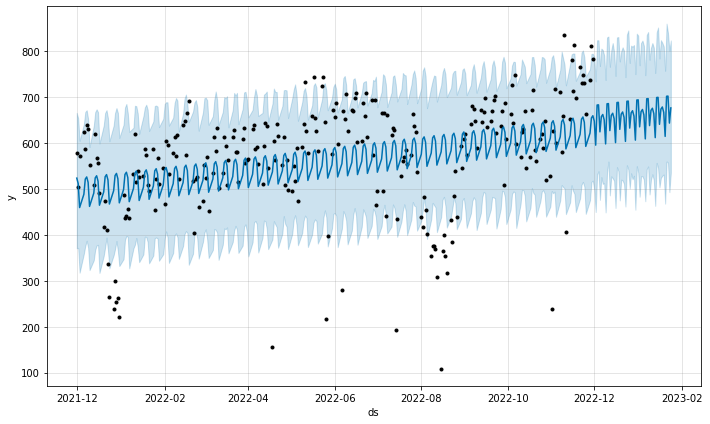

In [199]:
# Visualize the forecast
model_baseline.plot(forecast_baseline); # Add semi-colon to remove the duplicated chart

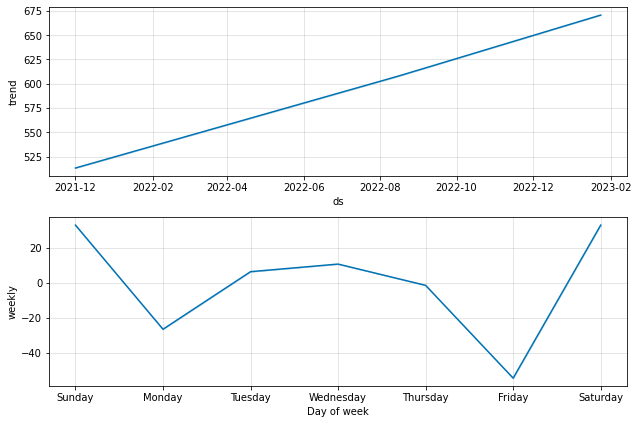

In [200]:
# Visualize the forecast components
model_baseline.plot_components(forecast_baseline);

In [201]:
forecast_baseline

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-12-01,513.269490,371.104586,666.025783,513.269490,513.269490,10.575963,10.575963,10.575963,10.575963,10.575963,10.575963,0.0,0.0,0.0,523.845453
1,2021-12-02,513.636250,371.894411,653.972344,513.636250,513.636250,-1.517420,-1.517420,-1.517420,-1.517420,-1.517420,-1.517420,0.0,0.0,0.0,512.118830
2,2021-12-03,514.003010,317.812970,605.141216,514.003010,514.003010,-54.291654,-54.291654,-54.291654,-54.291654,-54.291654,-54.291654,0.0,0.0,0.0,459.711356
3,2021-12-06,515.103290,359.090821,641.451245,515.103290,515.103290,-26.485366,-26.485366,-26.485366,-26.485366,-26.485366,-26.485366,0.0,0.0,0.0,488.617924
4,2021-12-07,515.470050,376.011955,668.043799,515.470050,515.470050,6.256136,6.256136,6.256136,6.256136,6.256136,6.256136,0.0,0.0,0.0,521.726186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311,2023-01-20,669.052586,468.283447,757.680160,668.973478,669.135766,-54.291654,-54.291654,-54.291654,-54.291654,-54.291654,-54.291654,0.0,0.0,0.0,614.760932
312,2023-01-21,669.441667,560.108213,860.381681,669.360004,669.527312,32.731163,32.731163,32.731163,32.731163,32.731163,32.731163,0.0,0.0,0.0,702.172831
313,2023-01-22,669.830749,557.691063,839.903248,669.746676,669.918102,32.731179,32.731179,32.731179,32.731179,32.731179,32.731179,0.0,0.0,0.0,702.561928
314,2023-01-23,670.219830,493.320314,801.333840,670.132949,670.310316,-26.485366,-26.485366,-26.485366,-26.485366,-26.485366,-26.485366,0.0,0.0,0.0,643.734464


In [202]:
test

,ds,y,headcount
261,2022-12-01,597.0,948
262,2022-12-02,514.0,948
263,2022-12-05,693.0,948
264,2022-12-06,756.0,948
265,2022-12-07,755.0,948
266,2022-12-08,761.0,948
267,2022-12-09,638.0,948
268,2022-12-12,545.0,948
269,2022-12-13,616.0,948
270,2022-12-14,609.0,948


In [203]:
# Merge actual and predicted values
performance_baseline = pd.merge(test, forecast_baseline[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-55:], on='ds')

In [204]:
# Check MAE value
performance_baseline_MAE = mean_absolute_error(performance_baseline['y'], performance_baseline['yhat'])
print(f'The MAE for the baseline model is {performance_baseline_MAE}')

The MAE for the baseline model is 119.13666506694416


In [205]:
# Check MAPE value
performance_baseline_MAPE = mean_absolute_percentage_error(performance_baseline['y'], performance_baseline['yhat'])
print(f'The MAPE for the baseline model is {performance_baseline_MAPE}')

The MAPE for the baseline model is 0.28648997404882476


### 6.2: Add Seasonality to Baseline Model

In [206]:
# Add seasonality
model_season = Prophet(yearly_seasonality=True, weekly_seasonality=True) 

In [207]:
# Fit the model on the training dataset
model_season.fit(train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpon5sxtje/j79ihbbz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpon5sxtje/3bvb6osf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98115', 'data', 'file=/tmp/tmpon5sxtje/j79ihbbz.json', 'init=/tmp/tmpon5sxtje/3bvb6osf.json', 'output', 'file=/tmp/tmpon5sxtje/prophet_modeleg92ty9v/prophet_model-20230223131233.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:12:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:12:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


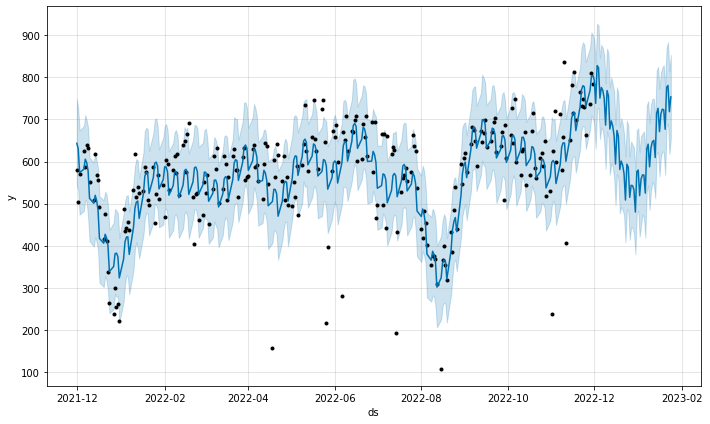

In [208]:
# Create the time range for the forecast
future_season = model_season.make_future_dataframe(periods=55)# Make prediction
forecast_season = model_season.predict(future_season)# Visualize the forecast
model_season.plot(forecast_season); # Add semi-colon to remove the duplicated chart

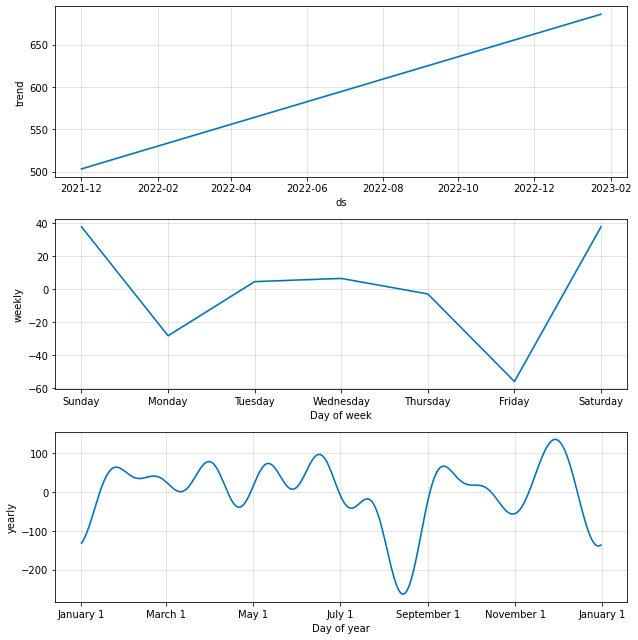

In [209]:
# Visualize the forecast components
model_season.plot_components(forecast_season);

In [210]:
# Merge actual and predicted values
performance_season = pd.merge(test, forecast_season[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-55:], on='ds')

# Check MAE value
performance_season_MAE = mean_absolute_error(performance_season['y'], performance_season['yhat'])
print(f'The MAE for the seasonality model is {performance_season_MAE}')

# Check MAPE value
performance_season_MAPE = mean_absolute_percentage_error(performance_season['y'], performance_season['yhat'])
print(f'The MAPE for the seasonality model is {performance_season_MAPE}')

The MAE for the seasonality model is 86.84710775516211
The MAPE for the seasonality model is 0.201779757324268


### 6.3: Multiplicative

In [211]:
# Add seasonality
model_multi_season = Prophet(yearly_seasonality=True, weekly_seasonality=True, seasonality_mode='multiplicative')

In [212]:
# Fit the model on the training dataset
model_multi_season.fit(train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpon5sxtje/n1wnywa5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpon5sxtje/zusub1fw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14691', 'data', 'file=/tmp/tmpon5sxtje/n1wnywa5.json', 'init=/tmp/tmpon5sxtje/zusub1fw.json', 'output', 'file=/tmp/tmpon5sxtje/prophet_model4du5qjdf/prophet_model-20230223131234.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:12:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:12:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


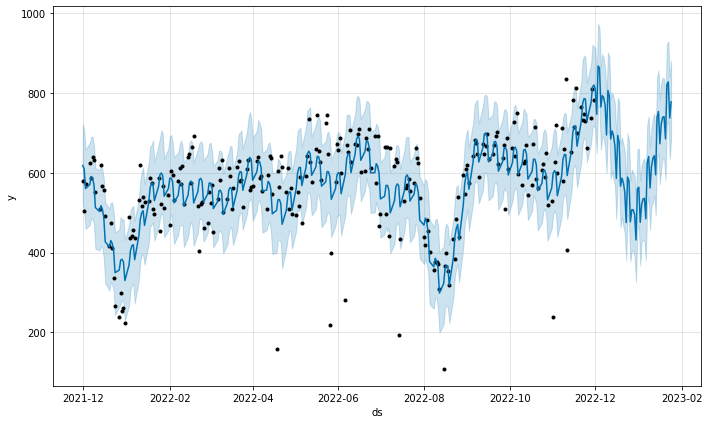

In [213]:
# Create the time range for the forecast
future_multi_season = model_multi_season.make_future_dataframe(periods=55)# Make prediction
forecast_multi_season = model_multi_season.predict(future_multi_season)# Visualize the forecast
model_multi_season.plot(forecast_multi_season); # Add semi-colon to remove the duplicated chart

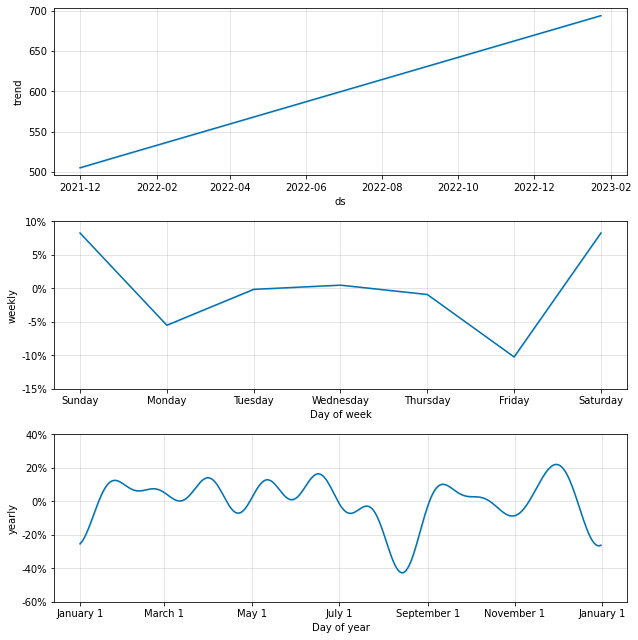

In [214]:
# Visualize the forecast components
model_multi_season.plot_components(forecast_multi_season);

In [215]:
# Merge actual and predicted values
performance_multi_season = pd.merge(test, forecast_multi_season[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-55:], on='ds')

# Check MAE value
performance_multi_season_MAE = mean_absolute_error(performance_multi_season['y'], performance_multi_season['yhat'])
print(f'The MAE for the seasonality model is {performance_season_MAE}')

# Check MAPE value
performance_multi_season_MAPE = mean_absolute_percentage_error(performance_multi_season['y'], performance_multi_season['yhat'])
print(f'The MAPE for the seasonality model is {performance_multi_season_MAPE}')

The MAE for the seasonality model is 86.84710775516211
The MAPE for the seasonality model is 0.1887351016028585


### 6.4: Multivariate Model

In [216]:
# Add seasonality 
model_multivariate = Prophet(seasonality_mode='multiplicative', yearly_seasonality=True, weekly_seasonality=True)

# Add regressor
model_multivariate.add_regressor('headcount', standardize=False)

# Fit the model on the training dataset
model_multivariate.fit(train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpon5sxtje/552_zcgs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpon5sxtje/qb4g256a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77550', 'data', 'file=/tmp/tmpon5sxtje/552_zcgs.json', 'init=/tmp/tmpon5sxtje/qb4g256a.json', 'output', 'file=/tmp/tmpon5sxtje/prophet_model4x6aquc2/prophet_model-20230223131236.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:12:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:12:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [217]:
# Create the time range for the forecast
future_multivariate = model_multivariate.make_future_dataframe(periods=55)

# Append the regressor values
future_multivariate = pd.merge(future_multivariate, df[['ds', 'headcount']], on='ds', how='inner')

# Fill the missing values with the previous value
future_multivariate = future_multivariate.fillna(method='ffill')

# Check the data
future_multivariate.tail(10)

,ds,headcount
290,2023-01-11,966
291,2023-01-12,966
292,2023-01-13,966
293,2023-01-16,966
294,2023-01-17,966
295,2023-01-18,966
296,2023-01-19,966
297,2023-01-20,966
298,2023-01-23,966
299,2023-01-24,966


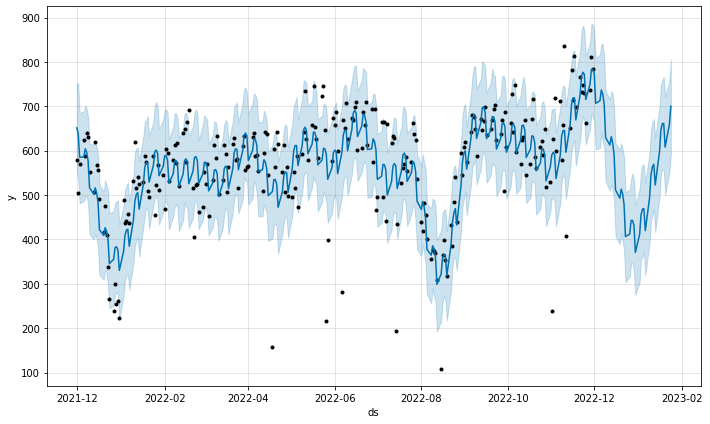

In [218]:
# Make prediction
forecast_multivariate = model_multivariate.predict(future_multivariate)

# Visualize the forecast
model_multivariate.plot(forecast_multivariate); # Add semi-colon to remove the duplicated chart

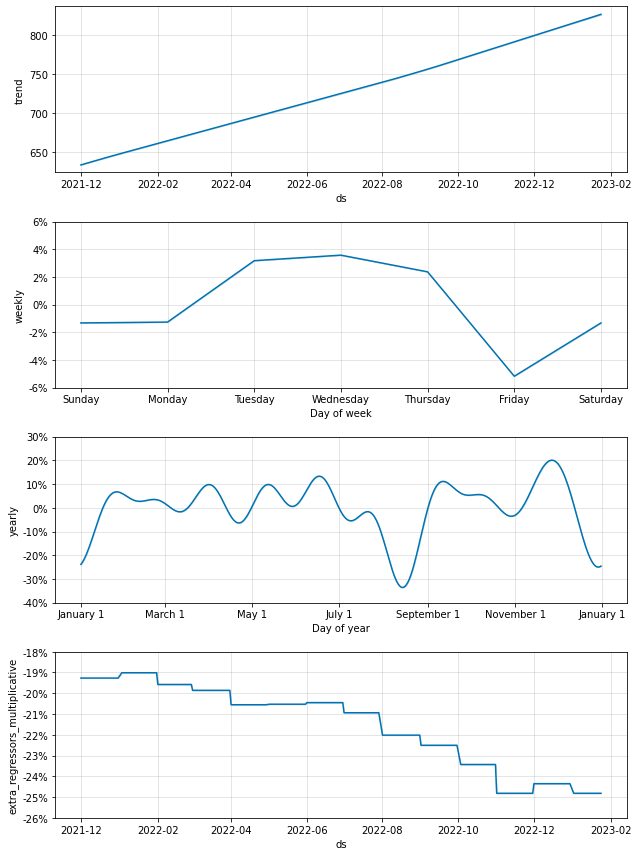

In [219]:
# Visualize the forecast components
model_multivariate.plot_components(forecast_multivariate);

In [220]:
# Merge actual and predicted values
performance_multivariate = pd.merge(test, forecast_multivariate[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-55:], on='ds')

# Check MAE value
performance_multivariate_MAE = mean_absolute_error(performance_multivariate['y'], performance_multivariate['yhat'])
print(f'The MAE for the multivariate model is {performance_multivariate_MAE}')

# Check MAPE value
performance_multivariate_MAPE = mean_absolute_percentage_error(performance_multivariate['y'], performance_multivariate['yhat'])
print(f'The MAPE for the multivariate model is {performance_multivariate_MAPE}')

The MAE for the multivariate model is 78.07570970582911
The MAPE for the multivariate model is 0.15352829178743035


### 6.5: Model with Holiday Effect and Event Effect

In [ ]:
# Christmas vacation time window
christmas = pd.DataFrame({
    'holiday': 'Christmas',
    'ds': pd.to_datetime(['2021-12-19','2022-12-18']),
    'lower_window': -1,
    'upper_window': 14,    
})

# Winter vacation time window
winter = pd.DataFrame({
    'holiday': 'Winter',
    'ds': pd.to_datetime(['2022-02-20','2023-02-19']),
    'lower_window': -1,
    'upper_window': 14,    
})

# Easter vacation time window
easter = pd.DataFrame({
    'holiday': 'Easter',
    'ds': pd.to_datetime(['2022-04-24']),#, '2023-04-23']),
    'lower_window': -1,
    'upper_window': 14,    
})

# Summer vacation time window
summer = pd.DataFrame({
    'holiday': 'Summer',
    'ds': pd.to_datetime(['2022-07-08']),
    'lower_window': -1,
    'upper_window': 54,    
})

# Fall vacation time window
fall = pd.DataFrame({
    'holiday': 'Fall',
    'ds': pd.to_datetime(['2022-10-23']),#, 
    'lower_window': -1,
    'upper_window': 14,    
})

# Combine all events
events = pd.concat((christmas, winter, easter, summer, fall))

# Take a look at the events data
events

In [281]:
events

,holiday,ds,lower_window,upper_window
0,Christmas,2021-12-19,-1,14
1,Christmas,2022-12-18,-1,14
0,Winter,2022-02-20,-1,14
1,Winter,2023-02-19,-1,14
0,Easter,2022-04-24,-1,14
0,Summer,2022-07-08,-1,54
0,Fall,2022-10-23,-1,14


In [271]:
# Add events (vacations)
model_holiday = Prophet(seasonality_mode='multiplicative', yearly_seasonality=True, weekly_seasonality=True, holidays=events)

In [272]:
# Add built-in country-specific holidays
model_holiday.add_country_holidays(country_name='FR')

In [273]:
# Add regressor
model_holiday.add_regressor('headcount', standardize=False)

In [274]:
# Fit the model on the training dataset
model_holiday.fit(train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpon5sxtje/y67xbn4u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpon5sxtje/1hqtujjr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32914', 'data', 'file=/tmp/tmpon5sxtje/y67xbn4u.json', 'init=/tmp/tmpon5sxtje/1hqtujjr.json', 'output', 'file=/tmp/tmpon5sxtje/prophet_modelwvv3s94g/prophet_model-20230223141533.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:15:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:15:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [275]:
# All the holidays and events
model_holiday.train_holiday_names

0              Christmas
1                 Winter
2                 Easter
3                 Summer
4                   Fall
5           Jour de l'an
6        Fête du Travail
7         Armistice 1945
8         Fête nationale
9         Armistice 1918
10       Lundi de Pâques
11    Lundi de Pentecôte
12             Ascension
13            Assomption
14             Toussaint
15                  Noël
dtype: object

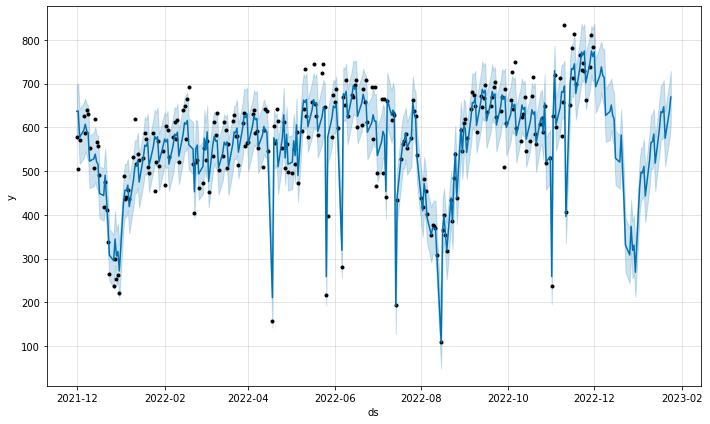

In [276]:
# Create the time range for the forecast
future_holiday = model_holiday.make_future_dataframe(periods=55)

# Append the regressor values
future_holiday = pd.merge(future_holiday, df[['ds', 'headcount']], on='ds', how='inner')

# Fill the missing values with the previous value
future_holiday = future_holiday.fillna(method='ffill')

# Make prediction
forecast_holiday = model_holiday.predict(future_holiday)

# Visualize the forecast
model_holiday.plot(forecast_holiday); # Add semi-colon to remove the duplicated chart

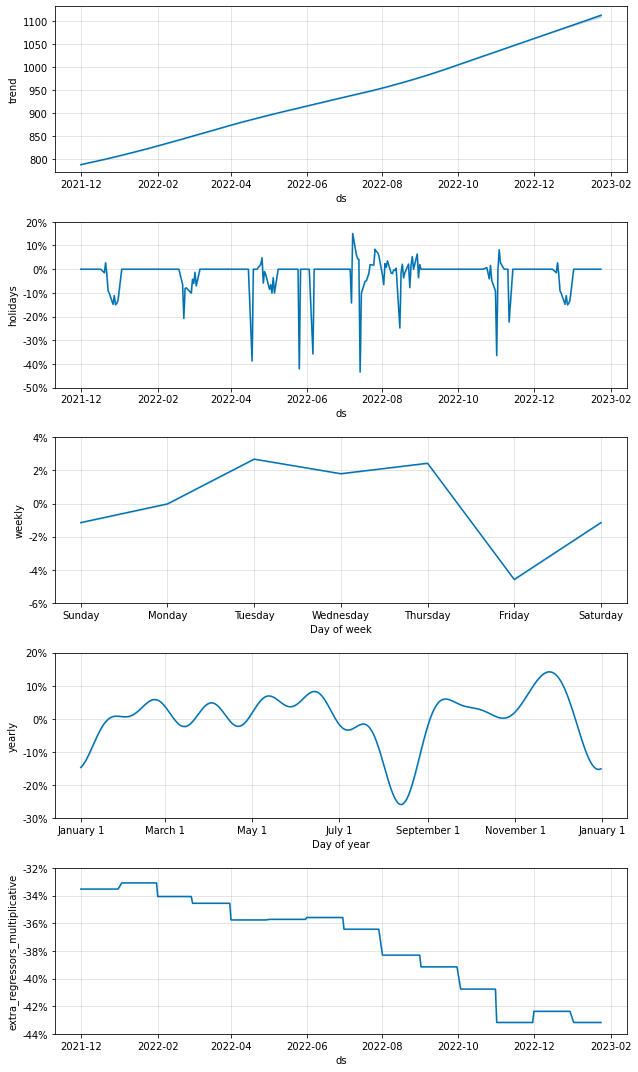

In [277]:
# Visualize the forecast components
model_holiday.plot_components(forecast_holiday);

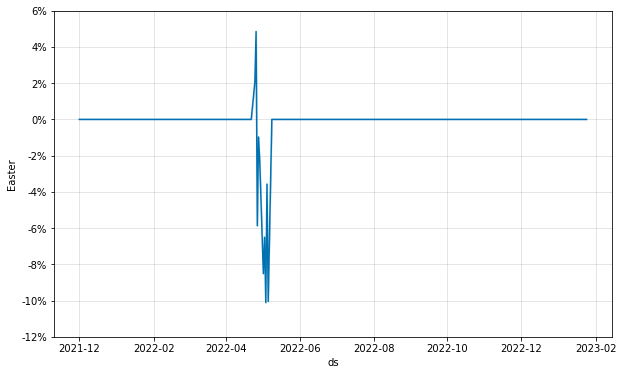

In [278]:
from prophet.plot import plot_forecast_component
plot_forecast_component(model_holiday, forecast_holiday, 'Easter') 

In [279]:
# Merge actual and predicted values
performance_holiday = pd.merge(test, forecast_holiday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-55:], on='ds')

# Check MAE value
performance_holiday_MAE = mean_absolute_error(performance_holiday['y'], performance_holiday['yhat'])
print(f'The MAE for the holiday/event model is {performance_holiday_MAE}')

# Check MAPE value
performance_holiday_MAPE = mean_absolute_percentage_error(performance_holiday['y'], performance_holiday['yhat'])
print(f'The MAPE for the holiday/event model is {performance_holiday_MAPE}')

The MAE for the holiday/event model is 70.8796681862911
The MAPE for the holiday/event model is 0.1237954095426656
